# Import relevant libraries

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from math import sin, cos, sqrt, atan2, radians
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
import statsmodels.formula.api as smf

np.random.seed(0)

# Load the Data 

In [3]:
tournament_Data = pd.read_csv('NCAA_Tourney_2002_2025.csv').query("season!=2019").reset_index(drop=True)
tournament_Data.head()

,team1_id,team1_score,team2_id,team2_score,WLoc,num_ot,team1_position,team2_position,team1_seed,team2_seed,...,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,game_id
0,1314,81.0,1181,77.0,N,0.0,W08,X02,8,2,...,113.035,100.974,96.9911,68.2765,67.4185,117.1520,119.3570,98.2346,95.6444,2022-1314-1181
1,1242,81.0,1437,65.0,N,0.0,Y01,Z02,1,2,...,119.388,97.191,93.9009,64.1915,62.5758,112.8450,117.9210,97.6798,93.8099,2022-1242-1437
2,1242,72.0,1314,69.0,N,0.0,Y01,W08,1,8,...,119.388,97.191,93.9009,70.2181,70.1745,109.4160,113.0350,100.9740,96.9911,2022-1242-1314
3,1242,76.0,1274,50.0,N,0.0,Y01,Y10,1,10,...,119.388,97.191,93.9009,67.5221,67.3101,110.3680,114.7570,104.9830,102.1320,2022-1242-1274
4,1314,69.0,1389,49.0,N,0.0,W08,W15,8,15,...,113.035,100.974,96.9911,67.0262,65.9923,98.7557,98.7475,92.3289,94.4745,2022-1314-1389


In [4]:
# The data has team1 as the winner. We need to create balanced training data
# by also including the reverse matchups (team2 vs team1)
print("\nPreparing training data...")



Preparing training data...


In [5]:
df_winner = tournament_Data.copy()
df_winner['target'] = 1  # team1 wins
df_loser = tournament_Data.copy()
df_loser['target'] = 0  # team2 loses

team1_cols = [c for c in tournament_Data.columns if c.startswith('team1_')]
team2_cols = [c for c in tournament_Data.columns if c.startswith('team2_')]


# Put Team 2 data into Team 1's columns
df_loser[team1_cols] = tournament_Data[team2_cols].values

# Put Team 1 data into Team 2's columns
df_loser[team2_cols] = tournament_Data[team1_cols].values


df_training = pd.concat([df_winner, df_loser], axis=0).reset_index(drop=True)
df_training = df_training.sort_values(by=['game_id']).reset_index(drop=True)
df_training.head()

,team1_id,team1_score,team2_id,team2_score,WLoc,num_ot,team1_position,team2_position,team1_seed,team2_seed,...,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,game_id,target
0,1104,86.0,1194,78.0,N,0.0,Y02,Y15,2,15,...,95.2313,93.877,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,2002-1104-1194,1
1,1194,78.0,1104,86.0,N,0.0,Y15,Y02,15,2,...,98.4183,99.9263,69.8636,69.9001,108.4361,111.4954,95.2313,93.877,2002-1104-1194,0
2,1112,86.0,1364,81.0,N,0.0,Z03,Z14,3,14,...,104.0411,96.9262,63.2345,64.7948,105.2163,105.4534,96.0965,97.6704,2002-1112-1364,1
3,1364,81.0,1112,86.0,N,0.0,Z14,Z03,14,3,...,96.0965,97.6704,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,2002-1112-1364,0
4,1461,60.0,1112,68.0,N,0.0,Z11,Z03,11,3,...,97.0568,96.6601,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,2002-1112-1461,0


# Pre-processing

In [6]:
print("Initial Shape:", tournament_Data.shape)
print("")
tournament_Data.info()

Initial Shape: (1447, 66)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   team1_id           1447 non-null   int64  
 1   team1_score        1447 non-null   float64
 2   team2_id           1447 non-null   int64  
 3   team2_score        1447 non-null   float64
 4   WLoc               1447 non-null   object 
 5   num_ot             1447 non-null   float64
 6   team1_position     1447 non-null   object 
 7   team2_position     1447 non-null   object 
 8   team1_seed         1447 non-null   int64  
 9   team2_seed         1447 non-null   int64  
 10  strongseed         1447 non-null   int64  
 11  weakseed           1447 non-null   int64  
 12  team1_region       1447 non-null   object 
 13  team2_region       1447 non-null   object 
 14  slot               1447 non-null   object 
 15  team1_teamname     1447 non-null   object 
 1

In [7]:
# Drop duplicates
tournament_Data = tournament_Data.drop_duplicates().reset_index(drop=True)

In [8]:
# Data types
num_cols = tournament_Data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = tournament_Data.select_dtypes(include=['object']).columns

In [9]:
# Imputing medians for numerical ones
tournament_Data[num_cols] = tournament_Data[num_cols].fillna(
    tournament_Data[num_cols].median())

In [10]:
# Imputing modes for categorical ones
for col in cat_cols:
    tournament_Data[col] = tournament_Data[col].fillna(
        tournament_Data[col].mode()[0])

In [11]:
# Final missing value check
print("\nMissing Values After Cleaning:\n")
print(tournament_Data.isnull().sum().sort_values(ascending=False).head(10))

print("\nFinal Shape:", tournament_Data.shape)


Missing Values After Cleaning:

team1_id            0
team2_arate         0
team1_arate         0
team1_opparate      0
team1_stlrate       0
team1_oppstlrate    0
team2_fg2pct        0
team2_fg3pct        0
team2_ftpct         0
team2_blockpct      0
dtype: int64

Final Shape: (1447, 66)


In [12]:
# Checking for outliers
Q1 = tournament_Data[num_cols].quantile(0.25)
Q3 = tournament_Data[num_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((tournament_Data[num_cols] < (Q1 - 1.5 * IQR)) | 
            (tournament_Data[num_cols] > (Q3 + 1.5 * IQR))).sum()

print("Potential Outliers per Feature:\n", outliers.sort_values(ascending=False).head(10))

Potential Outliers per Feature:
 team1_long          79
num_ot              79
host_long           72
team2_long          38
strongseed          37
team2_fg2pct        27
team2_oppf3grate    23
team1_fg2pct        22
team1_oe            22
team1_opparate      21
dtype: int64


# Feature Selection

In [14]:

# FEATURE SELECTION 

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel


if "df_training" in globals():
    data = df_training.copy()
elif "tournament_Data" in globals():
    
    df_winner = tournament_Data.copy()
    df_winner["target"] = 1

    df_loser = tournament_Data.copy()
    df_loser["target"] = 0

    team1_cols = [c for c in tournament_Data.columns if c.startswith("team1_")]
    team2_cols = [c for c in tournament_Data.columns if c.startswith("team2_")]

    df_loser[team1_cols] = tournament_Data[team2_cols].values
    df_loser[team2_cols] = tournament_Data[team1_cols].values

    data = pd.concat([df_winner, df_loser], axis=0).reset_index(drop=True)
else:
    raise NameError("I can't find df_training or tournament_Data in memory. Run your earlier cells first.")


# 1) Define X and y

y = data["target"].astype(int)
X = data.drop(columns=["target"]).copy()



# 2) Drop leakage + ID columns
#    (these are post-game or identifiers)
leak_cols = ["team1_score", "team2_score", "WLoc", "num_ot", "game_id"]
to_drop = [c for c in leak_cols if c in X.columns]
X = X.drop(columns=to_drop)

print("Dropped leakage/ID columns:", to_drop)


# 3) Build matchup DIFFERENCE features (team1 - team2) for numeric pairs
#    This is the best representation for "who is stronger in this matchup?"

team1_cols = [c for c in X.columns if c.startswith("team1_")]
diff_cols = []

for c1 in team1_cols:
    c2 = "team2_" + c1[len("team1_"):]
    if c2 in X.columns:
        # only create diffs for numeric columns
        if pd.api.types.is_numeric_dtype(X[c1]) and pd.api.types.is_numeric_dtype(X[c2]):
            new_col = "diff_" + c1[len("team1_"):]
            X[new_col] = X[c1] - X[c2]
            diff_cols.append(new_col)

# seed diff is especially useful
if "team1_seed" in X.columns and "team2_seed" in X.columns:
    X["seed_diff"] = X["team1_seed"] - X["team2_seed"]
    diff_cols.append("seed_diff")

# Keep ONLY diff features + safe context columns 
context_cols = [c for c in ["season", "slot", "host"] if c in X.columns]
X = X[diff_cols + context_cols].copy()

print("Diff features created:", len(diff_cols))
print("Context features kept:", context_cols)
print("Final feature count pre-encoding:", X.shape[1])


# 4) Split BEFORE selecting features (prevents leakage from test set)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


# 5) Preprocess (though imputed earlier, this is robust and safe)

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols),
        ("cat", categorical_preprocess, cat_cols)
    ],
    remainder="drop"
)


# 6) L1 Logistic Regression Feature Selection
#    - L1 sets weak feature weights to 0
#    - SelectFromModel keeps only non-zero features

l1_model = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.2,          # smaller means fewer features; increase to keep more (e.g., 0.5 or 1.0)
    max_iter=8000,
    n_jobs=-1,
    random_state=42
)

selector = SelectFromModel(l1_model, threshold=0.0)

feature_select_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", selector)
])

feature_select_pipe.fit(X_train, y_train)



# 7) Get selected feature names + transform data

all_feature_names = feature_select_pipe.named_steps["preprocess"].get_feature_names_out()
selected_mask = feature_select_pipe.named_steps["select"].get_support()
selected_feature_names = all_feature_names[selected_mask]

print("\nTotal encoded features:", len(all_feature_names))
print("Selected features:", len(selected_feature_names))

print("\nSelected features (first 80):")
for f in selected_feature_names[:80]:
    print(" -", f)

X_train_selected = feature_select_pipe.transform(X_train)
X_test_selected  = feature_select_pipe.transform(X_test)

print("\nShapes after selection:")
print("X_train_selected:", X_train_selected.shape)
print("X_test_selected :", X_test_selected.shape)


Dropped leakage/ID columns: ['team1_score', 'team2_score', 'WLoc', 'num_ot', 'game_id']
Diff features created: 1
Context features kept: ['season', 'slot', 'host']
Final feature count pre-encoding: 4

Total encoded features: 181
Selected features: 181

Selected features (first 80):
 - num__season
 - cat__seed_diff_-15
 - cat__seed_diff_-13
 - cat__seed_diff_-12
 - cat__seed_diff_-11
 - cat__seed_diff_-10
 - cat__seed_diff_-9
 - cat__seed_diff_-8
 - cat__seed_diff_-7
 - cat__seed_diff_-6
 - cat__seed_diff_-5
 - cat__seed_diff_-4
 - cat__seed_diff_-3
 - cat__seed_diff_-2
 - cat__seed_diff_-1
 - cat__seed_diff_0
 - cat__seed_diff_1
 - cat__seed_diff_2
 - cat__seed_diff_3
 - cat__seed_diff_4
 - cat__seed_diff_5
 - cat__seed_diff_6
 - cat__seed_diff_7
 - cat__seed_diff_8
 - cat__seed_diff_9
 - cat__seed_diff_10
 - cat__seed_diff_11
 - cat__seed_diff_12
 - cat__seed_diff_13
 - cat__seed_diff_15
 - cat__slot_R1W1
 - cat__slot_R1W2
 - cat__slot_R1W3
 - cat__slot_R1W4
 - cat__slot_R1W5
 - cat__s

In [15]:
X["seed_diff"] = pd.to_numeric(X["seed_diff"], errors="coerce")

# Predictions

                      accuracy       auc   logloss
ExtraTrees            0.642487  0.713125  0.620918
RandomForest          0.645941  0.711001  0.615805
LogisticRegression    0.652850  0.702494  0.627007
HistGradientBoosting  0.645941  0.701873  0.633378
XGBoost               0.601036  0.646713  0.711369
KNN                   0.628670  0.623279  2.509132
SVM_RBF               0.616580  0.582556  0.681564


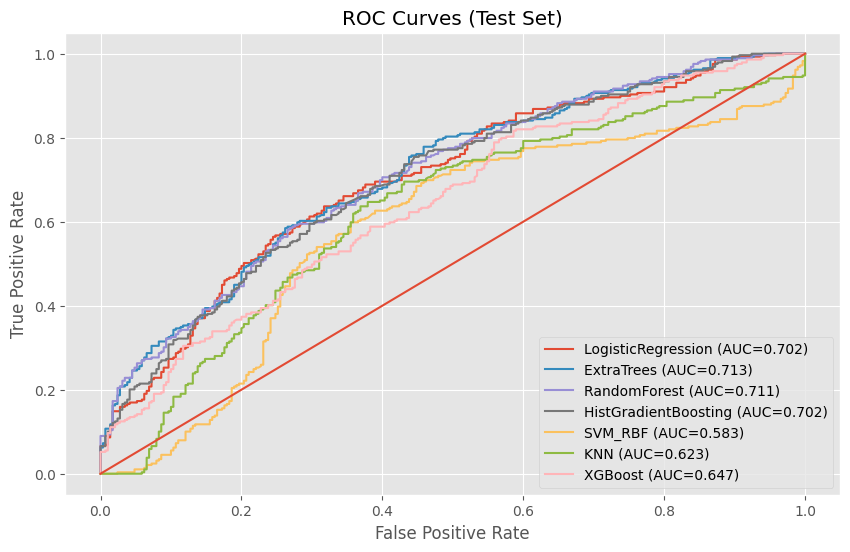

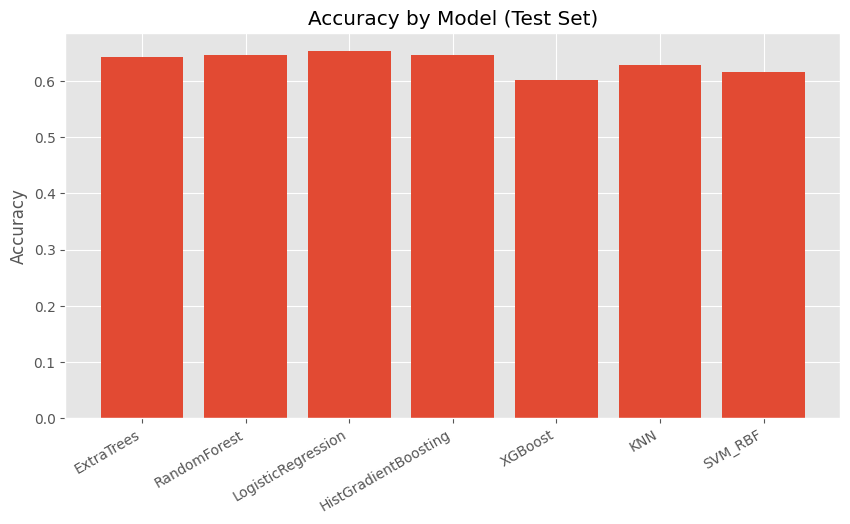

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def to_dense_if_sparse(M):
    return M.toarray() if hasattr(M, "toarray") else M

Xtr_sparse = X_train_selected
Xte_sparse = X_test_selected
Xtr_dense  = to_dense_if_sparse(Xtr_sparse)
Xte_dense  = to_dense_if_sparse(Xte_sparse)

try:
    from xgboost import XGBClassifier
    xgb_ok = True
except Exception as e:
    xgb_ok = False
    print("XGBoost not available. Install with: pip install xgboost")
    print("Import error:", e)

models = {
    "LogisticRegression": LogisticRegression(max_iter=8000, n_jobs=-1),

    "ExtraTrees": ExtraTreesClassifier(n_estimators=1200, random_state=42, n_jobs=-1, min_samples_leaf=2),
    "RandomForest": RandomForestClassifier(n_estimators=800, random_state=42, n_jobs=-1, min_samples_leaf=2),

    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42, max_depth=6, learning_rate=0.06, max_iter=400),

    "SVM_RBF": SVC(probability=True, kernel="rbf", C=2.0, gamma="scale", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=35, weights="distance"),
}

if xgb_ok:
    models["XGBoost"] = XGBClassifier(
        n_estimators=900,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss"
    )

dense_only = {"HistGradientBoosting", "SVM_RBF", "KNN"}

results = {}
roc_lines = {}

for name, model in models.items():
    Xtr = Xtr_dense if name in dense_only else Xtr_sparse
    Xte = Xte_dense if name in dense_only else Xte_sparse

    model.fit(Xtr, y_train)

    proba = model.predict_proba(Xte)[:, 1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    ll  = log_loss(y_test, proba)

    results[name] = {"accuracy": acc, "auc": auc, "logloss": ll}

    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_lines[name] = (fpr, tpr)

metrics_df = pd.DataFrame(results).T.sort_values("auc", ascending=False)
print(metrics_df)


plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_lines.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={results[name]['auc']:.3f})")
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.bar(metrics_df.index, metrics_df["accuracy"].values)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Accuracy")
plt.title("Accuracy by Model (Test Set)")
plt.show()


Epoch 01 | loss=0.6945
Epoch 02 | loss=0.6936
Epoch 03 | loss=0.6933
Epoch 04 | loss=0.6933
Epoch 05 | loss=0.6935
Epoch 06 | loss=0.6933
Epoch 07 | loss=0.6935
Epoch 08 | loss=0.6934
Epoch 09 | loss=0.6934
Epoch 10 | loss=0.6932
Epoch 11 | loss=0.6933
Epoch 12 | loss=0.6932
{'RNN_GRU_accuracy': 0.5008635578583766, 'RNN_GRU_auc': 0.4771745615081733, 'RNN_GRU_logloss': 0.6931751971623646}


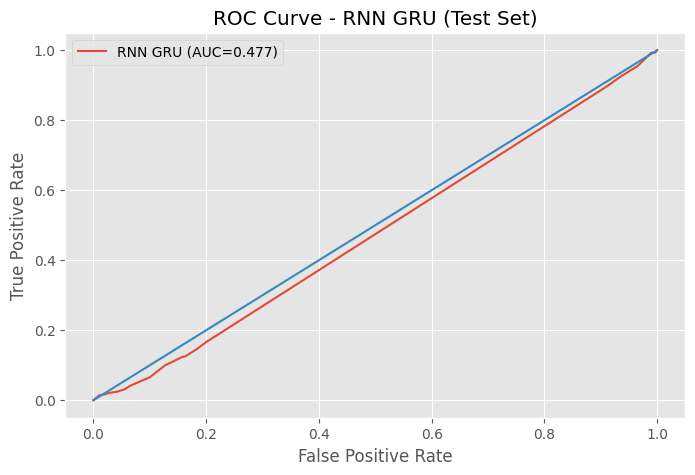

In [18]:
#RNN
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, roc_curve
import matplotlib.pyplot as plt

def to_dense(M):
    return M.toarray() if hasattr(M, "toarray") else M

Xtr_dense = to_dense(X_train_selected)
Xte_dense = to_dense(X_test_selected)

Xtr = torch.tensor(Xtr_dense, dtype=torch.float32)
Xte = torch.tensor(Xte_dense, dtype=torch.float32)
ytr = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
yte = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

Xtr_seq = Xtr.unsqueeze(-1) 
Xte_seq = Xte.unsqueeze(-1)

train_loader = DataLoader(TensorDataset(Xtr_seq, ytr), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte_seq, yte), batch_size=256, shuffle=False)

class GRUClassifier(nn.Module):
    def __init__(self, hidden=48):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=hidden, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        logits = self.fc(last)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUClassifier(hidden=48).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
for epoch in range(12):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1:02d} | loss={total/len(train_loader.dataset):.4f}")

# Predict
model.eval()
with torch.no_grad():
    logits = model(Xte_seq.to(device)).cpu().numpy().reshape(-1)
    proba = 1 / (1 + np.exp(-logits))
    pred = (proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)
ll  = log_loss(y_test, proba)

print({"RNN_GRU_accuracy": acc, "RNN_GRU_auc": auc, "RNN_GRU_logloss": ll})

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"RNN GRU (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RNN GRU (Test Set)")
plt.legend()
plt.show()


# Git

In [19]:
!git init
!git add .
!git commit -m "Initial commit"
!gh repo create SethiDeepika/MarchMadness --public --source=. --remote=origin --push

Initialized empty Git repository in C:/Users/Amogha/Downloads/.git/
^C


fatal: Unable to create 'C:/Users/Amogha/Downloads/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure all processes
are terminated then try again. If it still fails, a git process
may have crashed in this repository earlier:
remove the file manually to continue.
'gh' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
%%bash
git init
git add .
git commit -m "Initial commit"

Reinitialized existing Git repository in /mnt/c/Users/Amogha/Downloads/.git/


fatal: Unable to create '/mnt/c/Users/Amogha/Downloads/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure all processes
are terminated then try again. If it still fails, a git process
may have crashed in this repository earlier:
remove the file manually to continue.
fatal: Unable to create '/mnt/c/Users/Amogha/Downloads/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure all processes
are terminated then try again. If it still fails, a git process
may have crashed in this repository earlier:
remove the file manually to continue.


CalledProcessError: Command 'b'git init\ngit add .\ngit commit -m "Initial commit"\n'' returned non-zero exit status 128.

In [33]:
cd /workspaces/AIML/MarchMadness
git init
git add .
git commit -m "Initial commit"
gh repo create your-username/MarchMadness --public --source=. --remote=origin
git push -u origin main

SyntaxError: invalid syntax (1955416861.py, line 2)

In [35]:
gh repo create MarchMadness --public --source=. --remote=origin --push

SyntaxError: invalid syntax (1038429445.py, line 1)